In [110]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [111]:
!apt-get update
!apt-get install -y fonts-noto


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease         
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease                                    
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                   
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/u

In [112]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

In [113]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [116]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [117]:
print(df['label'].unique())


['Non Informative' 'Cyclone' 'Anthropogenic' 'Earthquake' 'River Erosion'
 'flood']


In [118]:
import pandas as pd

# Define the mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())


[1 4 2 3 0]


In [119]:
print(df['label'].value_counts())

label
4    697
0    510
1    509
2    500
3    445
Name: count, dtype: int64


In [120]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [121]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Prepare data for TextDataset
X_train = train_data['caption'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values


In [122]:
import random

# Random Deletion
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

# Random Swap
def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Character-level Noise
def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

# Combine all augmentations
def augment_bengali_text(text):
    # Step 1: Random Deletion
    text = random_deletion_bn(text, p=0.1)
    # Step 2: Random Swap
    text = random_swap_bn(text, n=1)
    # Step 3: Character-level noise
    text = char_noise_bn(text, p=0.03)
    return text

# Apply augmentation to your dataset
df['caption_aug'] = df['caption'].apply(augment_bengali_text)

print(df[['caption', 'caption_aug']].head(10))  # Check a sample


                                                caption  \
410       মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন   
1483  ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...   
1578  গাজা ও ইউক্রেন যুদ্ধ নিয়ে যে সতর্কবার্তা দিল ...   
1534  চীনের শেয়ারবাজারে অস্থিরতা, বিনিয়োগকারীদের ব...   
1235  ইটভাটা ও কারখানার ধোঁয়ায় রাতের আকাশ কালো হয়...   
584   “তুরস্ক-সিরিয়া সীমান্তে ভূমিকম্পে ৪,০০০+ মানুষ...   
994   স্কুলের মাঠটি গত সপ্তাহেও ছিল, আজ সেখানে শুধু ...   
3137                   জুম আর্থে ঘূর্ণিঝড় দানার অবস্থান   
3127  ঘূর্ণিঝড়ের প্রভাবে টানা বৃষ্টি ও ঝোড়ো হাওয়ায় দ...   
486   সবকিছু হারিয়েও কিছু মানুষ এখনও লড়ে যাচ্ছে, বে...   

                                            caption_aug  
410              তাণ্ডবে ঝড়ের বিদ্যুতের লাইন বিচ্ছিন্ন  
1483  প্লাস্টিক উপকূলে ফিনল্যান্ডের ও রাসায়নিক বর্ঔ...  
1578     গাজা ও ইউক্রেন দিল যে সতর্কবার্তা যুদ্ধ তুরস্ক  
1534          বিনিয়োগকারীদের থস্থিরতা, চীনের বড় ক্ষতি  
1235  থ যাচ্ছে, ধোঁয়ায় রাতের আকাশ কালো হয়ে কারখান...  
58

In [123]:
# 3️⃣ Tokenizer & Dataset
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding='max_length', truncation=True, max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_ds = TextDataset(X_train, y_train, tokenizer)
valid_ds = TextDataset(X_valid, y_valid, tokenizer)
test_ds = TextDataset(X_test, y_test, tokenizer)

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

In [124]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('sagorsarker/bangla-bert-base', num_labels=5).to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=0.3)
total_steps = len(train_dl) * 15
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

patience = 4
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(15):
    if early_stop:
        print("Early stopping triggered")
        break
    
    model.train()
    total_loss = 0
    correct, total = 0, 0
    for batch in tqdm(train_dl, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        weighted_loss = torch.mean(loss * class_weights[labels])  # Apply class weights
        weighted_loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += weighted_loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_dl)
    train_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in valid_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(valid_dl)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            early_stop = True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


Epoch 1, Training Loss: 1.5771, Training Accuracy: 29.70%
Validation Loss: 1.5086, Validation Accuracy: 34.59%


Epoch 2: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Epoch 2, Training Loss: 1.4583, Training Accuracy: 40.85%
Validation Loss: 1.4134, Validation Accuracy: 42.29%


Epoch 3: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


Epoch 3, Training Loss: 1.3609, Training Accuracy: 50.56%
Validation Loss: 1.3082, Validation Accuracy: 53.01%


Epoch 4: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Epoch 4, Training Loss: 1.2488, Training Accuracy: 60.71%
Validation Loss: 1.2033, Validation Accuracy: 58.65%


Epoch 5: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 5, Training Loss: 1.1446, Training Accuracy: 67.11%
Validation Loss: 1.0950, Validation Accuracy: 66.54%


Epoch 6: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Epoch 6, Training Loss: 1.0387, Training Accuracy: 73.56%
Validation Loss: 0.9874, Validation Accuracy: 73.87%


Epoch 7: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 7, Training Loss: 0.9428, Training Accuracy: 77.76%
Validation Loss: 0.8943, Validation Accuracy: 77.63%


Epoch 8: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 8, Training Loss: 0.8630, Training Accuracy: 81.08%
Validation Loss: 0.8154, Validation Accuracy: 80.45%


Epoch 9: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 9, Training Loss: 0.7978, Training Accuracy: 82.39%
Validation Loss: 0.7533, Validation Accuracy: 81.95%


Epoch 10: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Epoch 10, Training Loss: 0.7343, Training Accuracy: 84.46%
Validation Loss: 0.7028, Validation Accuracy: 83.46%


Epoch 11: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 11, Training Loss: 0.6976, Training Accuracy: 84.34%
Validation Loss: 0.6684, Validation Accuracy: 84.21%


Epoch 12: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Epoch 12, Training Loss: 0.6714, Training Accuracy: 85.15%
Validation Loss: 0.6418, Validation Accuracy: 85.15%


Epoch 13: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 13, Training Loss: 0.6426, Training Accuracy: 85.96%
Validation Loss: 0.6227, Validation Accuracy: 85.71%


Epoch 14: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 14, Training Loss: 0.6216, Training Accuracy: 86.72%
Validation Loss: 0.6125, Validation Accuracy: 86.09%


Epoch 15: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 15, Training Loss: 0.6192, Training Accuracy: 87.22%
Validation Loss: 0.6092, Validation Accuracy: 86.09%


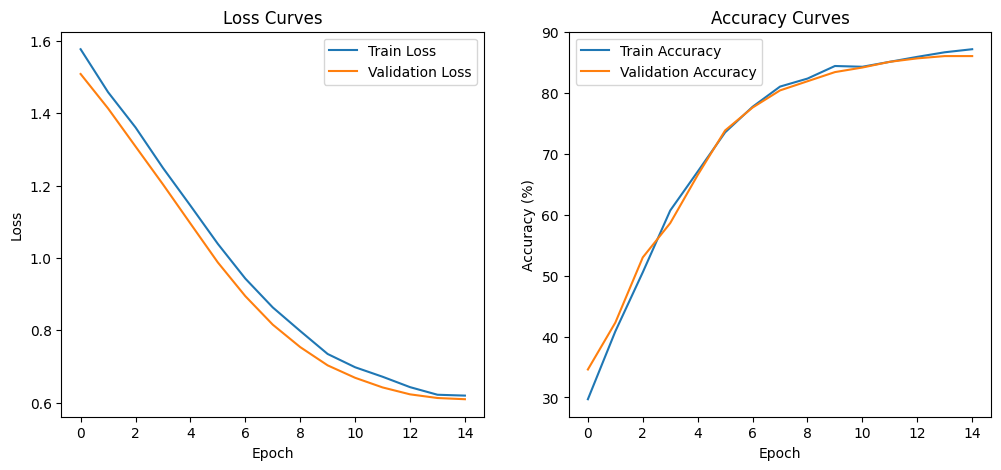

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.savefig('training_curves.png')  # Save the figure as a file

plt.show()


In [127]:
import pandas as pd

# Create a DataFrame for easy visualization
df = pd.DataFrame({
    'Epoch': range(1, len(train_losses)+1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy (%)': train_accuracies,
    'Validation Accuracy (%)': val_accuracies
})

print(df)

# Optionally, save to a CSV file for later analysis
df.to_csv('training_metrics.csv', index=False)


    Epoch  Train Loss  Validation Loss  Train Accuracy (%)  \
0       1    1.577057         1.508580           29.699248   
1       2    1.458290         1.413368           40.852130   
2       3    1.360874         1.308191           50.563910   
3       4    1.248803         1.203300           60.714286   
4       5    1.144610         1.095048           67.105263   
5       6    1.038707         0.987365           73.558897   
6       7    0.942831         0.894263           77.756892   
7       8    0.863037         0.815379           81.077694   
8       9    0.797827         0.753325           82.393484   
9      10    0.734274         0.702797           84.461153   
10     11    0.697596         0.668441           84.335840   
11     12    0.671360         0.641806           85.150376   
12     13    0.642603         0.622672           85.964912   
13     14    0.621576         0.612533           86.716792   
14     15    0.619178         0.609177           87.218045   

    Val

Test Accuracy: 86.30%

Classification Report:
              precision    recall  f1-score   support

           0     0.8529    0.8286    0.8406       105
           1     0.8113    0.8515    0.8309       101
           2     0.9057    0.8136    0.8571       118
           3     0.9487    0.8605    0.9024        86
           4     0.8298    0.9512    0.8864       123

    accuracy                         0.8630       533
   macro avg     0.8697    0.8611    0.8635       533
weighted avg     0.8668    0.8630    0.8630       533



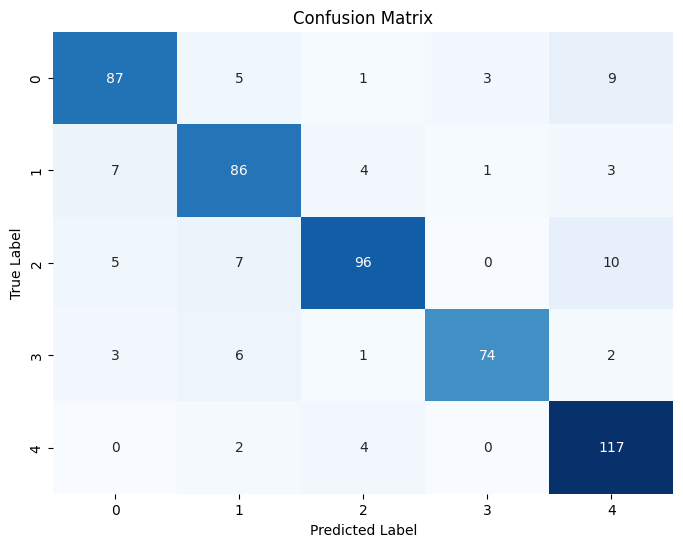

In [128]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = 100 * (sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels))
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
